# Data 분석

## raw data 관찰

sampled는 비교를 위해 여러 군데에서 무작위로 샘플링한거 같고<br/>

rtt는 시간순에 따라서 크롤링한 데이터로 보임(slack이나 영화)

초반 데이터를 보면 back translation을 이미 적용한 것 같다

train-024 <br/>
sentence_1: 군대가기전에 봤었는데 진짜 윈터스같은 사람이 상관이면 목숨걸고 싸워도 후회는 없지 않을까? 라고 생각했던게 기억이 나네요 ㅎㅎ <br/>

sentence_2: 입대하기 전에 봤는데 윈터스 같은 사람이 진심으로 아껴준다면 목숨을 걸고 싸워도 후회는 없겠죠? 라고 생각했던 기억이 나네요 ㅎㅎ

이건 어떻게 봐도 semantic text exchange로 만든 pair


rtt는 semantic text exchange가 적용된 느낌이 많이 들고<br/>
sampled는 상대적으로 raw data가 많아보임(아닐수도 있음)

train-014, 019, 020는 전부 sampled data인데<br> 유사도 점수가 0, 실제로도 문장간 연관성이 없어보임

그에 비해 train-027~029는 모두 back translation이나<br/>
비슷한 데이터 증강 기법(semantic text exchange)으로 만들어낸 pair 같다


확인해보고 싶은 내용 : semantic text exchange로 구성한 pair가 얼마나 될까

## 

## 분포 확인

### 1차로 확인하고 싶은 내용
- sampled/rtt별 label 분포
- nsmc, slack, petition의 label 분포

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('raw/train.csv')

# source와 label 확인
print(df[['source', 'label']].head())

# source에서 'sampled'와 'rtt' 추출
df['source_type'] = df['source'].apply(lambda x: 'sampled' if 'sampled' in x else 'rtt')

# main source(nsmc, slack, petition) 추출
df['main_source'] = df['source'].apply(lambda x: 'nsmc' if 'nsmc' in x else ('slack' if 'slack' in x else 'petition'))


             source  label
0      nsmc-sampled    2.2
1         slack-rtt    4.2
2  petition-sampled    2.4
3     slack-sampled    3.0
4     slack-sampled    0.0


/var/folders/81/10vzgccj1vsc6zgyjw21rxgw0000gn/T/ipykernel_27741/3312209859.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='source_type', y='label', data=df, estimator=lambda x: len(x), ci=None)
/var/folders/81/10vzgccj1vsc6zgyjw21rxgw0000gn/T/ipykernel_27741/3312209859.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='main_source', y='label', data=df, estimator=lambda x: len(x), ci=None)


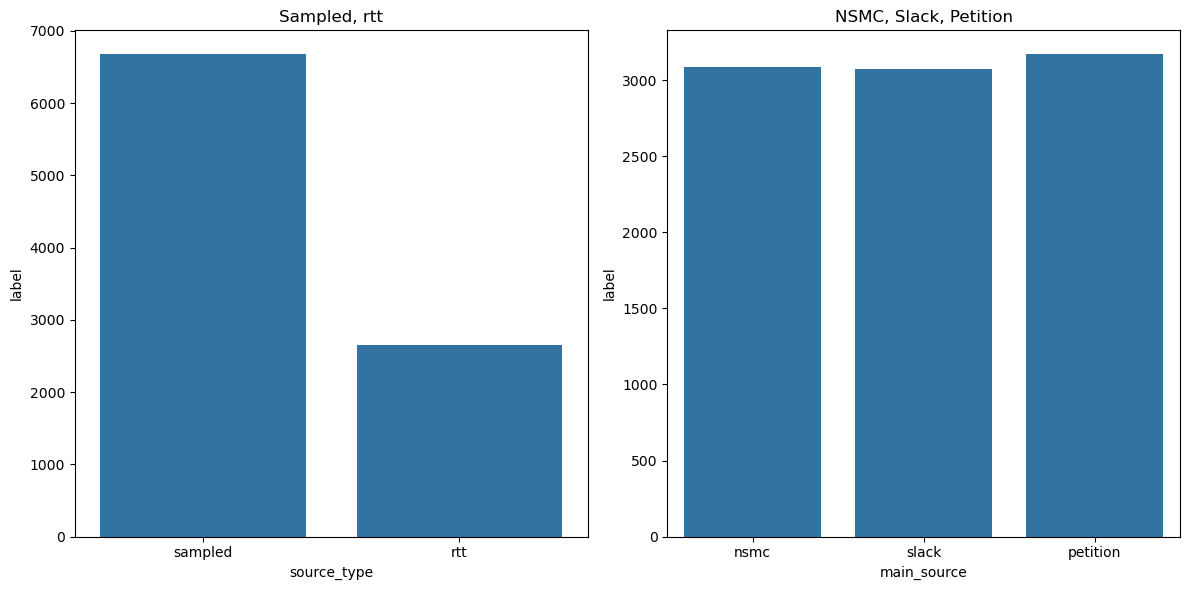

In [4]:
# 시각화
## sampled/rtt 별 label 분포
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='source_type', y='label', data=df, estimator=lambda x: len(x), ci=None)
plt.title('Sampled, rtt')

## nsmc, slack, petition 별 label 분포
plt.subplot(1, 2, 2)
sns.barplot(x='main_source', y='label', data=df, estimator=lambda x: len(x), ci=None)
plt.title('NSMC, Slack, Petition')

plt.tight_layout()
plt.show()

In [9]:
# 전체 데이터 개수 및 sampled와 rtt의 비율 확인

total_data_count = len(df)
print(f"전체 데이터 개수: {total_data_count}")

type_counts = df['source_type'].value_counts()
#print(type_counts)
type_ratios = type_counts / total_data_count * 100
print(f"source type별 ratios: \n{type_ratios}")


전체 데이터 개수: 9324
source type별 ratios: 
source_type
sampled    71.557272
rtt        28.442728
Name: count, dtype: float64


전체 데이터 중 차지하는 비중은 nsmc, slack, petition 모두 비슷

전체 데이터 중 sampled와 rtt의 비율은 대충 7:3 정도

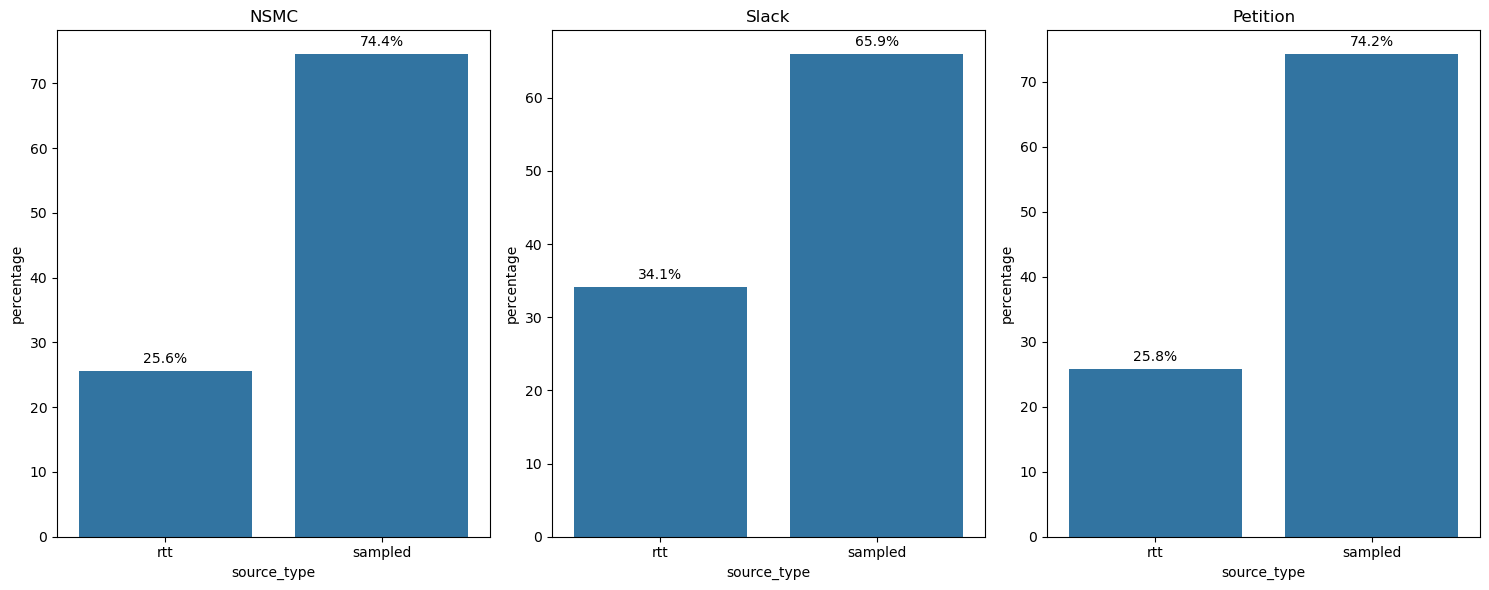

In [13]:
# 각 main_source와 source_type에 따라 데이터 개수 계산
grouped_data = df.groupby(['main_source', 'source_type']).size().reset_index(name='count')

# 전체 데이터 대비 퍼센트 계산 (각 출처 내에서 퍼센티지 계산)
total_counts = df.groupby('main_source').size().to_dict()
grouped_data['percentage'] = grouped_data.apply(lambda row: (row['count'] / total_counts[row['main_source']]) * 100, axis=1)

# 시각화 및 퍼센티지 값 표시
def add_percentage_labels(ax):
    """
    각 바 위에 퍼센트 값을 적어주는 함수
    """
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), textcoords='offset points')

plt.figure(figsize=(15, 6))

# NSMC 
plt.subplot(1, 3, 1)
ax1 = sns.barplot(x='source_type', y='percentage', data=grouped_data[grouped_data['main_source'] == 'nsmc'])
plt.title('NSMC')
add_percentage_labels(ax1)

# Slack 
plt.subplot(1, 3, 2)
ax2 = sns.barplot(x='source_type', y='percentage', data=grouped_data[grouped_data['main_source'] == 'slack'])
plt.title('Slack')
add_percentage_labels(ax2)

# Petition 
plt.subplot(1, 3, 3)
ax3 = sns.barplot(x='source_type', y='percentage', data=grouped_data[grouped_data['main_source'] == 'petition'])
plt.title('Petition')
add_percentage_labels(ax3)

plt.tight_layout()
plt.show()

각각에서의 sampled/rtt 비율도 비슷

/var/folders/81/10vzgccj1vsc6zgyjw21rxgw0000gn/T/ipykernel_27741/2202519223.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['main_source', 'source_type', 'label_range']).size().reset_index(name='count')


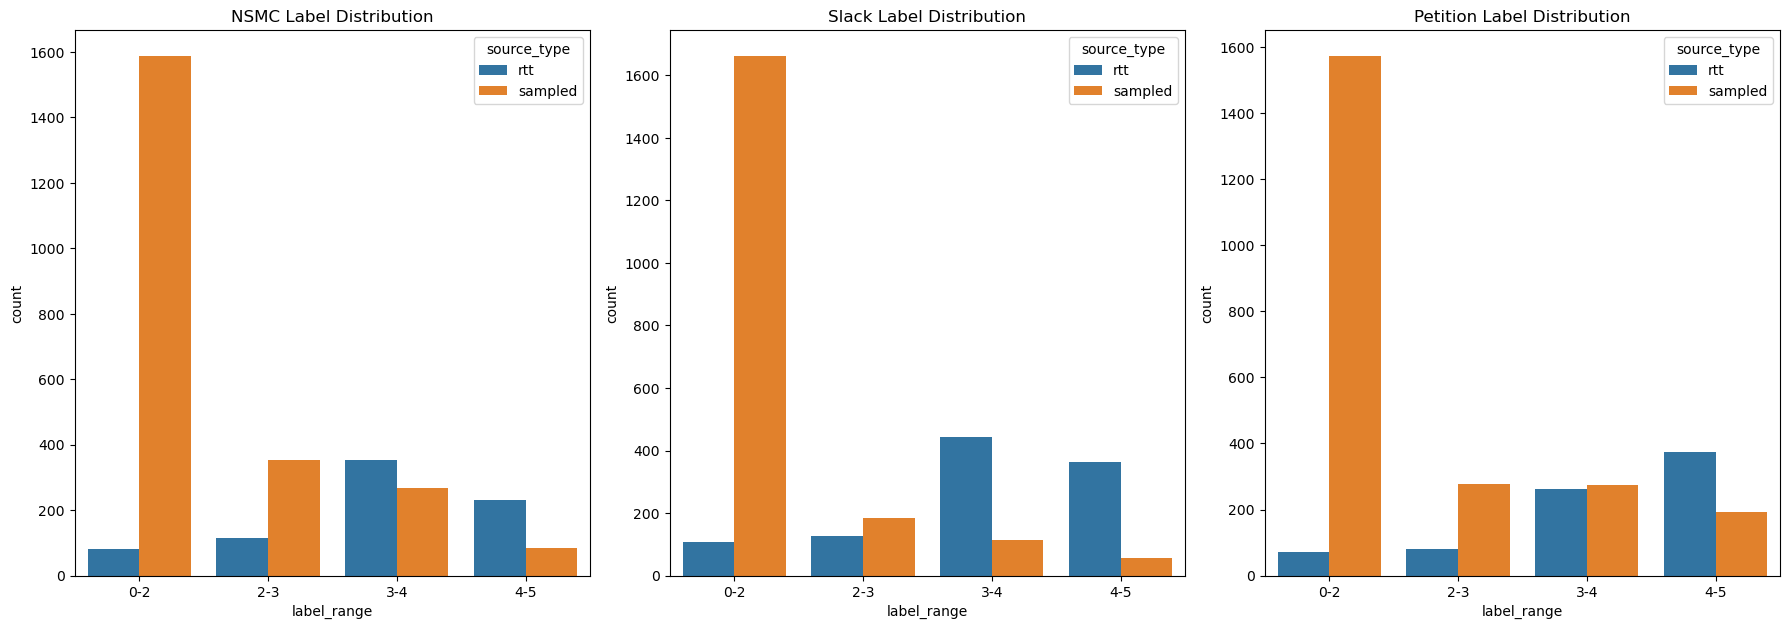

In [14]:
# label 범위 설정: 0~2, 2~3, 3~4, 4~5
df['label_range'] = pd.cut(df['label'], bins=[0, 2, 3, 4, 5], right=False, labels=['0-2', '2-3', '3-4', '4-5'])

# source와 label_range에 따른 데이터 개수 계산
grouped_data = df.groupby(['main_source', 'source_type', 'label_range']).size().reset_index(name='count')

# 시각화
plt.figure(figsize=(18, 12))

# NSMC
plt.subplot(2, 3, 1)
sns.barplot(x='label_range', y='count', hue='source_type', data=grouped_data[grouped_data['main_source'] == 'nsmc'])
plt.title('NSMC Label Distribution')

# Slack
plt.subplot(2, 3, 2)
sns.barplot(x='label_range', y='count', hue='source_type', data=grouped_data[grouped_data['main_source'] == 'slack'])
plt.title('Slack Label Distribution')

# Petition
plt.subplot(2, 3, 3)
sns.barplot(x='label_range', y='count', hue='source_type', data=grouped_data[grouped_data['main_source'] == 'petition'])
plt.title('Petition Label Distribution')

plt.tight_layout()
plt.show()

In [16]:
# nsmc 데이터 중에서 label이 4점을 넘는 데이터 필터링
nsmc_over_4 = df[(df['main_source'] == 'nsmc') & (df['label'] > 4)]

# 'sampled'와 'rtt'로 각각 나눔
nsmc_sampled_over_4 = nsmc_over_4[nsmc_over_4['source_type'] == 'sampled']
nsmc_rtt_over_4 = nsmc_over_4[nsmc_over_4['source_type'] == 'rtt']

# 각각의 데이터프레임을 CSV로 저장
nsmc_sampled_over_4.to_csv('nsmc_sampled_over_4.csv', index=False)
nsmc_rtt_over_4.to_csv('nsmc_rtt_over_4.csv', index=False)


nsmc 중에서 label 점수가 4점 이상인 데이터만 관찰해봤는데
99%(사실상 100%)가 semantic text exchange로 만든 pair였다

이러면 back translation 기법을 써도 큰 효과를 보기 어려움

일단 이 상태에서 baseline을 돌려보고 inference 성능을 확인해보자

In [17]:
# slack 데이터 중에서 label이 4점을 넘는 데이터 필터링
slack_over_4 = df[(df['main_source'] == 'slack') & (df['label'] > 4)]

# 'sampled'와 'rtt'로 각각 나눔
slack_sampled_over_4 = slack_over_4[slack_over_4['source_type'] == 'sampled']
slack_rtt_over_4 = slack_over_4[slack_over_4['source_type'] == 'rtt']

# 각각의 데이터프레임을 CSV로 저장
slack_sampled_over_4.to_csv('slack_sampled_over_4.csv', index=False)
slack_rtt_over_4.to_csv('slack_rtt_over_4.csv', index=False)

# petition 데이터 중에서 label이 4점을 넘는 데이터 필터링
petition_over_4 = df[(df['main_source'] == 'petition') & (df['label'] > 4)]

# 'sampled'와 'rtt'로 각각 나눔
petition_sampled_over_4 = petition_over_4[petition_over_4['source_type'] == 'sampled']
petition_rtt_over_4 = petition_over_4[petition_over_4['source_type'] == 'rtt']

# 각각의 데이터프레임을 CSV로 저장
petition_sampled_over_4.to_csv('petition_sampled_over_4.csv', index=False)
petition_rtt_over_4.to_csv('petition_rtt_over_4.csv', index=False)


slack과 petition도 4점 이상을 확인해보니 마찬가지로 99%(그냥 전부)가 semantic text exchange으로 만든 pair